## Import Library

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [3]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

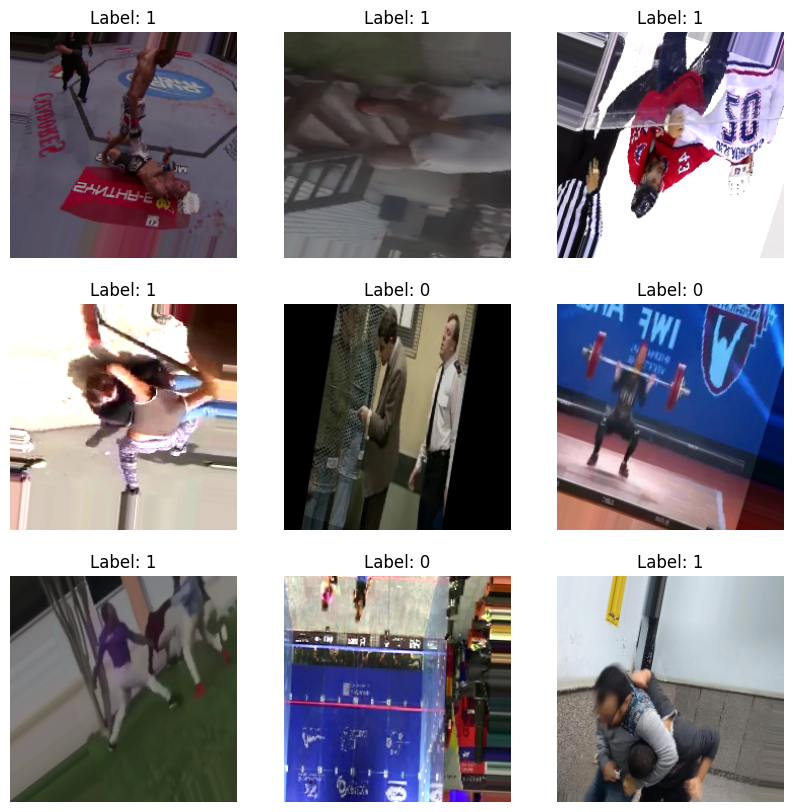

In [4]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [5]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze40_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6819 - loss: 1.2063 
Epoch 1: val_accuracy improved from -inf to 0.50682, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 1238s 25s/step - accuracy: 0.6825 - loss: 1.2046 - val_accuracy: 0.5068 - val_loss: 1.0109
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.7749 - loss: 0.8567
Epoch 2: val_accuracy did not improve from 0.50682
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.7748 - loss: 0.8569 - val_accuracy: 0.5023 - val_loss: 1.0597
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7825 - loss: 0.8120
Epoch 3: val_accuracy improved from 0.50682 to 0.56818, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 673ms/step - accuracy: 0.7826 - loss: 0.8118 - val_accuracy: 0.5682 - val_loss: 0.9428
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7912 - loss: 0.7714
Epoch 4: val_accuracy improved from 0.56818 to 0.64318, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 649ms/step - accuracy: 0.7910 - loss: 0.7714 - val_accuracy: 0.6432 - val_loss: 0.8914
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8021 - loss: 0.7465
Epoch 5: val_accuracy improved from 0.64318 to 0.68864, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.8024 - loss: 0.7457 - val_accuracy: 0.6886 - val_loss: 0.8024
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8126 - loss: 0.7254
Epoch 6: val_accuracy improved from 0.68864 to 0.80682, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.8128 - loss: 0.7247 - val_accuracy: 0.8068 - val_loss: 0.6834
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8130 - loss: 0.6725
Epoch 7: val_accuracy improved from 0.80682 to 0.82727, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 656ms/step - accuracy: 0.8128 - loss: 0.6730 - val_accuracy: 0.8273 - val_loss: 0.6338
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8307 - loss: 0.6611
Epoch 8: val_accuracy did not improve from 0.82727
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - accuracy: 0.8308 - loss: 0.6610 - val_accuracy: 0.8182 - val_loss: 0.6305
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8237 - loss: 0.6602
Epoch 9: val_accuracy improved from 0.82727 to 0.87955, saving model to NoMCLAHE_Freeze40_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - accuracy: 0.8235 - loss: 0.6602 - val_accuracy: 0.8795 - val_loss: 0.5390
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8358 - loss: 0.6055
Epoch 10: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 640ms/step - accuracy: 0.8356 - loss: 0.6059 - val_accuracy: 0.7886 - val_loss: 0.6818
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8472 - loss: 0.5701
Epoch 11: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.8470 - loss: 0.5707 - val_accuracy: 0.8182 - val_loss: 0.6434
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8166 - loss: 0.6262
Epoch 12: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 640ms/step - accuracy: 0.8167 - loss: 0.6261 - val_accuracy: 0.8455 - val_loss: 0.5890
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8478 - loss: 0.5756
Epoch 13: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 659ms/step - accuracy: 0.8463 - loss: 0.5244 - val_accuracy: 0.8955 - val_loss: 0.4446
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8524 - loss: 0.5300
Epoch 18: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 646ms/step - accuracy: 0.8523 - loss: 0.5301 - val_accuracy: 0.8886 - val_loss: 0.4463
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8469 - loss: 0.5281
Epoch 19: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 646ms/step - accuracy: 0.8470 - loss: 0.5282 - val_accuracy: 0.8545 - val_loss: 0.5041
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8518 - loss: 0.5194
Epoch 20: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 696ms/step - accuracy: 0.8519 - loss: 0.5193 - val_accuracy: 0.8659 - val_loss: 0.4579
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8463 - loss: 0.5395
Epoch 21: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - accuracy: 0.8575 - loss: 0.4808 - val_accuracy: 0.9182 - val_loss: 0.3876
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8472 - loss: 0.4854
Epoch 34: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - accuracy: 0.8474 - loss: 0.4852 - val_accuracy: 0.8568 - val_loss: 0.4638
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8853 - loss: 0.4146
Epoch 35: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.8851 - loss: 0.4151 - val_accuracy: 0.8909 - val_loss: 0.3892
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8704 - loss: 0.4271
Epoch 36: val_accuracy did not improve from 0.91818
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 635ms/step - accuracy: 0.8701 - loss: 0.4277 - val_accuracy: 0.8568 - val_loss: 0.4442
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8554 - loss: 0.4742
Epoch 37: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.8177 - loss: 0.5083
Validation Loss: 0.4017672836780548
Validation Accuracy: 0.8727272748947144


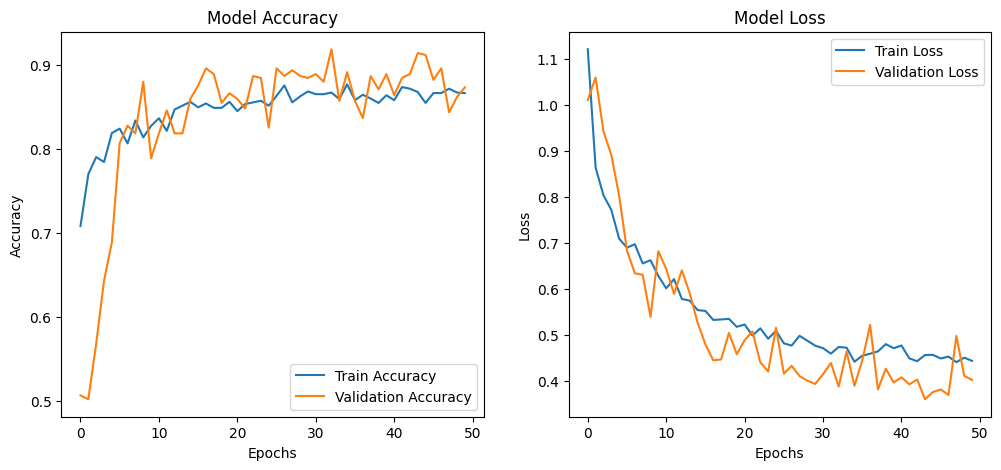

In [7]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [8]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze40_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 123s 20s/step - accuracy: 0.8218 - loss: 0.5385
Test Accuracy : 88.74%
Test Loss     : 0.409


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step


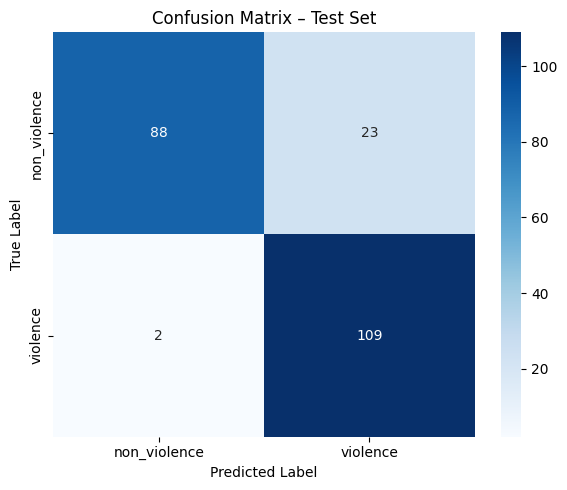


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.98      0.79      0.88       111
    violence       0.83      0.98      0.90       111

    accuracy                           0.89       222
   macro avg       0.90      0.89      0.89       222
weighted avg       0.90      0.89      0.89       222



In [9]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))